# importBoundariesAndStations.ipynb
The following script can be used to import the agriculture regions and their associated weather stations into the database

##### Required files:
- [REGIONS_FILE](https://www150.statcan.gc.ca/n1/fr/pub/92-174-x/2007000/carboundary/gcar000b07a_e.zip?st=uOKRCq3u)
- [STATIONS_FILE](https://dd.weather.gc.ca/climate/observations/climate_station_list.csv)

##### Output:
- [census_ag_regions](https://github.com/ChromaticPanic/CGC_Grain_Outcome_Predictions#census_ag_regions)
- [stations_dly](https://github.com/ChromaticPanic/CGC_Grain_Outcome_Predictions#stations_dly)
- [stations_hly](https://github.com/ChromaticPanic/CGC_Grain_Outcome_Predictions#stations_hly)

In [2]:
from matplotlib import pyplot as plt  # type: ignore
from dotenv import load_dotenv
import geopandas as gpd  # type: ignore
import pandas as pd
import os, sys

sys.path.append("../")
from Shared.DataService import DataService

e:\Programming\CGC_Grain_Outcome_Predictions\env\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\danew\AppData\Local\Temp\ipykernel_10432\3593560936.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be s

In [3]:
REGIONS_FILE = "data/2006CensusAgRegions/gcar000b07a_e.shp"  # The name of the regions file
STATIONS_FILE = "data/climate_station_list.csv"  # The name of the stations file

REGIONS_TABLE = "census_ag_regions"  # The name of the agriculture regions table
DLY_STATIONS_TABLE = "stations_dly"  # The name of the daily stations table
HLY_STATIONS_TABLE = "stations_hly"  # The name of the hourly stations table

# Adjust the granularity of reporting
pd.options.display.max_rows = 100
pd.options.display.float_format = "{:.1f}".format
pd.set_option("display.max_columns", None)


# Load the database connection environment variables located in the docker folder
load_dotenv("../docker/.env")
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

Purpose:  
Loads the regions and stations from their respective files directly into [DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)/[GeoDataFrames](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html)

In [4]:
regions = gpd.read_file(REGIONS_FILE, encoding="utf-8")
stations = pd.read_csv(STATIONS_FILE)

Purpose:  
Recreates the GeoDataFrame creating geometry from the provided longitude/latitude

Pseudocode:  
- Recreate the GeoDataFrames using the provided [longitude/latitude as the geometry points](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)
- Drop daily stations without data after 1995 (based on the attribute DLY Last Year)
- Drop hourly stations without data after 1995 (based on the attribute HLY Last Year)

In [5]:
stationsDly = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude)
)

stationsHly = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude)
)

stationsDly = stationsDly.loc[stations["DLY Last Year"] > 1995]
stationsHly = stationsHly.loc[stations["HLY Last Year"] > 1995]

Purpose:  
Puts all sets of geometries (regions and stations) onto the same coordinate system

Psuedocode:  
- [Set the region and corrdinate system](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.set_crs.html) as EPSG:4326 (default from data sources)
- [Change their coordinate system](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) to EPSG:3347 (desired coordinate system)

Remarks: EPSG:4326 is the coordinate system we often use day to day (i.e GPS)

In [6]:
regions = regions.set_crs("EPSG:4326", allow_override=True)
stationsDly = stationsDly.set_crs("EPSG:4326", allow_override=True)
stationsHly = stationsHly.set_crs("EPSG:4326", allow_override=True)

regions = regions.to_crs(crs="EPSG:3347")
stationsDly = stationsDly.to_crs(crs="EPSG:3347")
stationsHly = stationsHly.to_crs(crs="EPSG:3347")

Purpose:  
Creates a region plot for the agriculture regions and the hourly weather stations

Psuedocode:  
- [Generate the minimum and maximum bounds of the geography](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html)
- [Create a subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)
- [Assign the vertical view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)
- [Assign the hoirzontal view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html)
- [Assign a title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)
- [Plot the geometry/districts](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)
- [Plot the weather stations](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

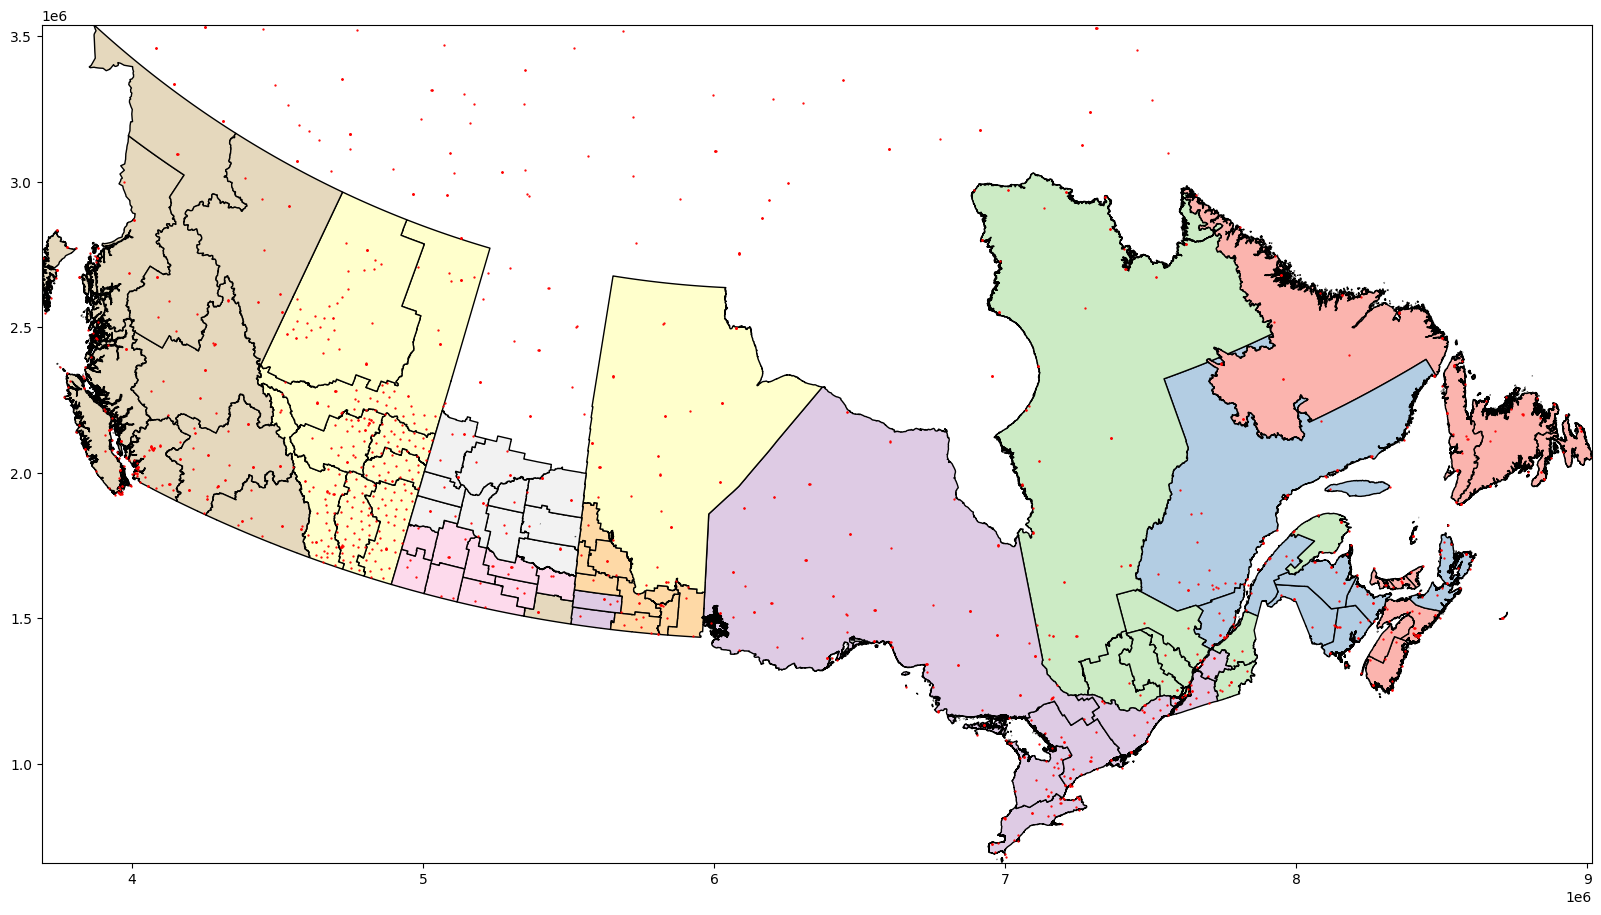

In [7]:
minx, miny, maxx, maxy = regions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("All Hourly Stations")
regions.plot(ax=ax, cmap="Pastel1", edgecolor="black")
stationsHly.plot(ax=ax, color="red", markersize=0.4)
plt.show()

Purpose:  
Creates a region plot for the agriculture regions and the daily weather stations

Psuedocode:  
- [Generate the minimum and maximum bounds of the geography](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html)
- [Create a subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)
- [Assign the vertical view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)
- [Assign the hoirzontal view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html)
- [Assign a title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)
- [Plot the geometry/districts](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)
- [Plot the weather stations](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

<Axes: title={'center': 'All Daily Stations'}>

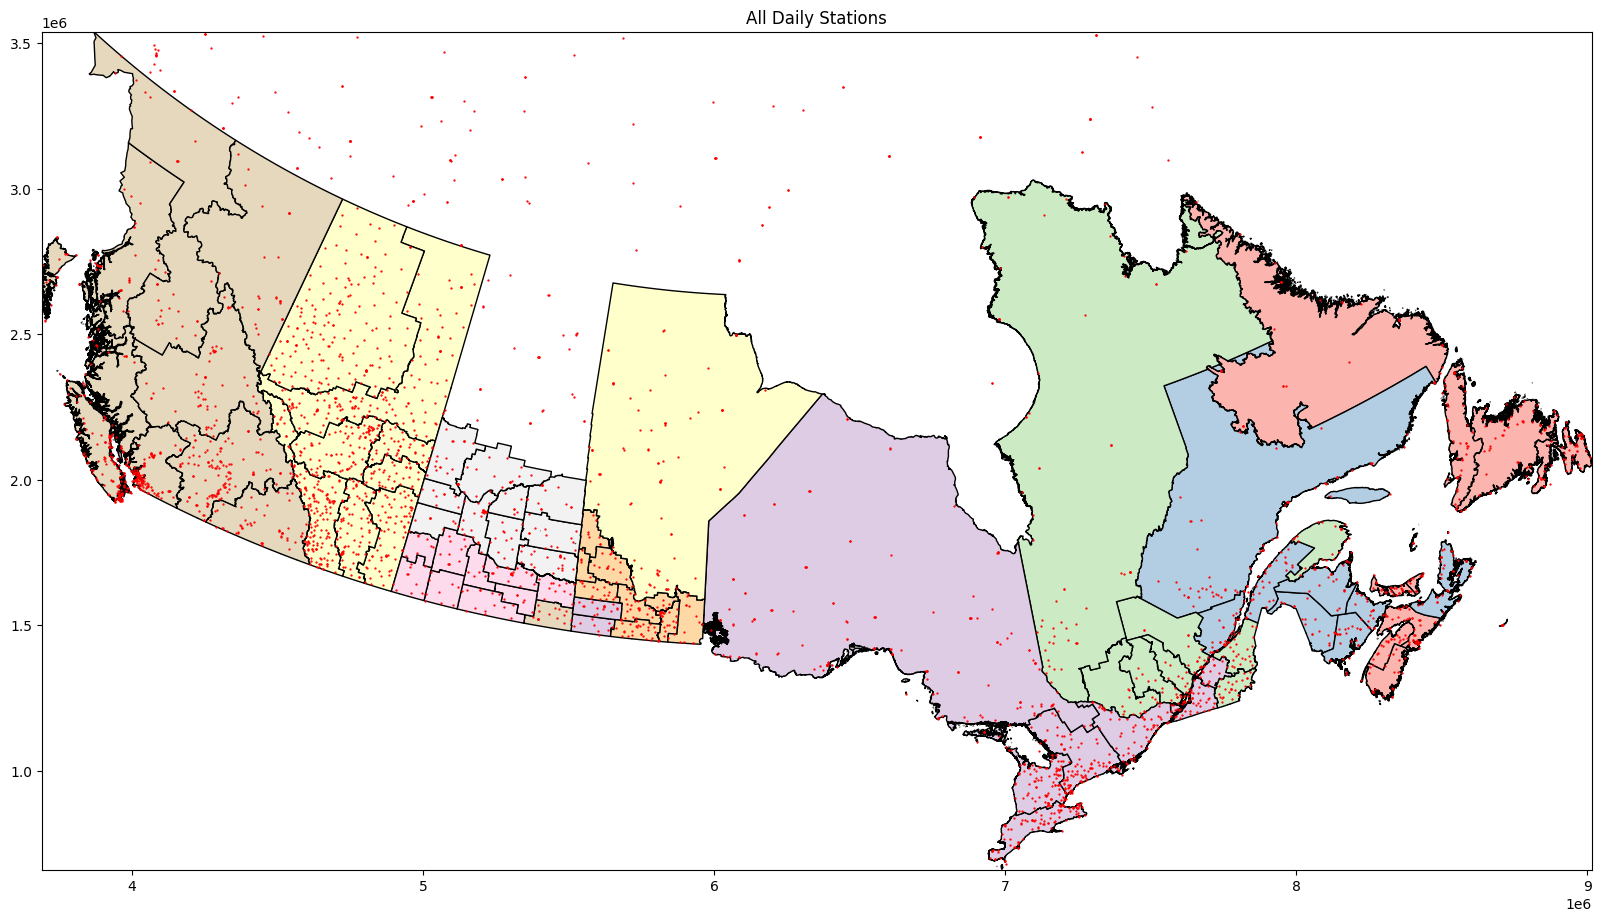

In [12]:
minx, miny, maxx, maxy = regions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("All Daily Stations")
regions.plot(ax=ax, cmap="Pastel1", edgecolor="black")
stationsDly.plot(ax=ax, color="red", markersize=0.4)

Purpose:  
Create a seperate GeoDataFrame to contain only the areas of interest

Pseudocode:  
- Create a deep copy of the original regions
- [Cast PRuid into an integer](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html)
- [Drop rows that have a PRuid other than 46, 47, 48](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)

In [9]:
prunedRegions = regions.copy(deep=True)
prunedRegions["PRuid"] = prunedRegions["PRuid"].astype(int)
prunedRegions = prunedRegions.loc[prunedRegions["PRuid"].isin([46, 47, 48])]

Purpose:  
Creates a region plot for the pruned agriculture regions (only shows Alberta, Manitoba and Saskatchewan)

Psuedocode:  
- [Generate the minimum and maximum bounds of the geography](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html)
- [Create a subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)
- [Assign the vertical view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)
- [Assign the hoirzontal view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html)
- [Assign a title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)
- [Plot the geometry/districts](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)
- [Plot the weather stations](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

<Axes: title={'center': 'All Hourly Stations in our Area of Interest'}>

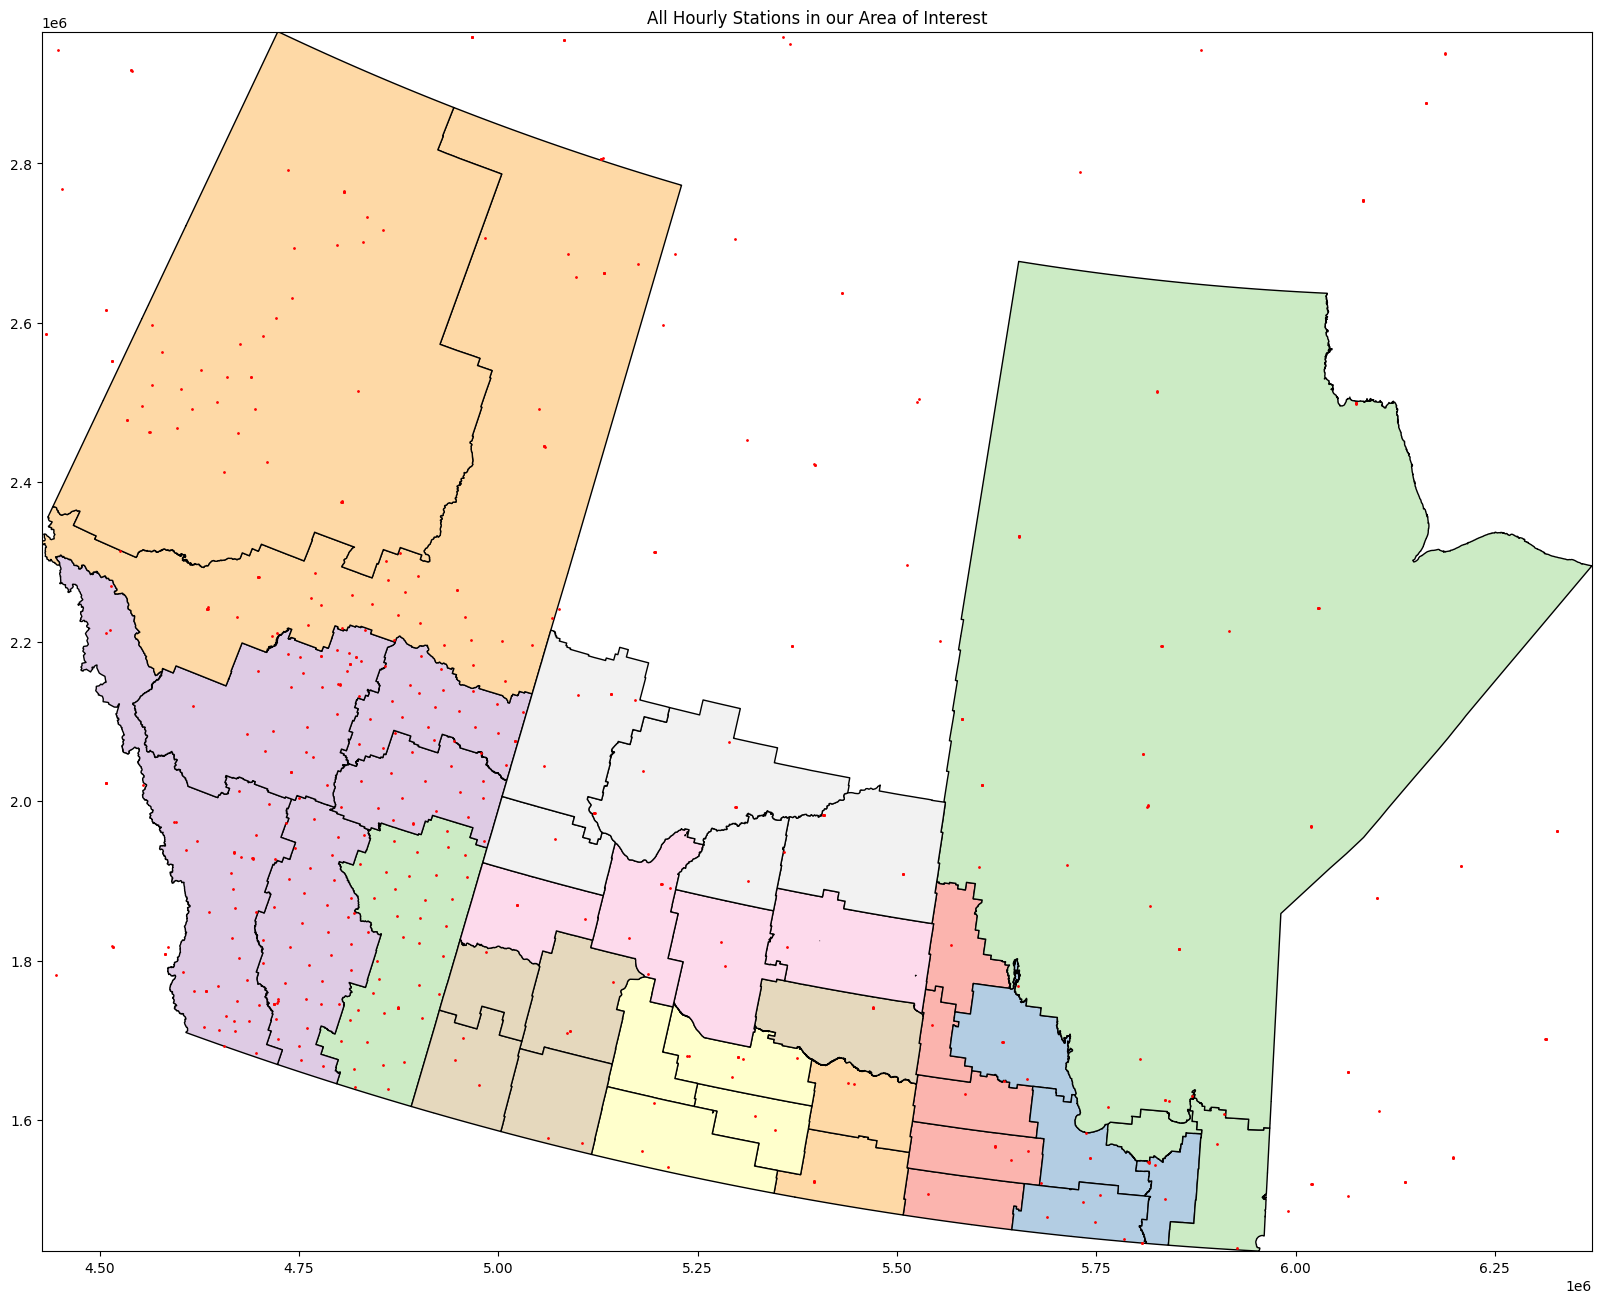

In [14]:
minx, miny, maxx, maxy = prunedRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("All Hourly Stations in our Area of Interest")
prunedRegions.plot(ax=ax, cmap="Pastel1", edgecolor="black")
stationsHly.plot(ax=ax, color="red", markersize=1)

Purpose:  
Creates a region plot for the pruned agriculture regions (only shows Alberta, Manitoba and Saskatchewan)

Psuedocode:  
- [Generate the minimum and maximum bounds of the geography](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html)
- [Create a subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)
- [Assign the vertical view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)
- [Assign the hoirzontal view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html)
- [Assign a title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)
- [Plot the geometry/districts](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)
- [Plot the weather stations](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

<Axes: title={'center': 'All Daily Stations in our Area of Interest'}>

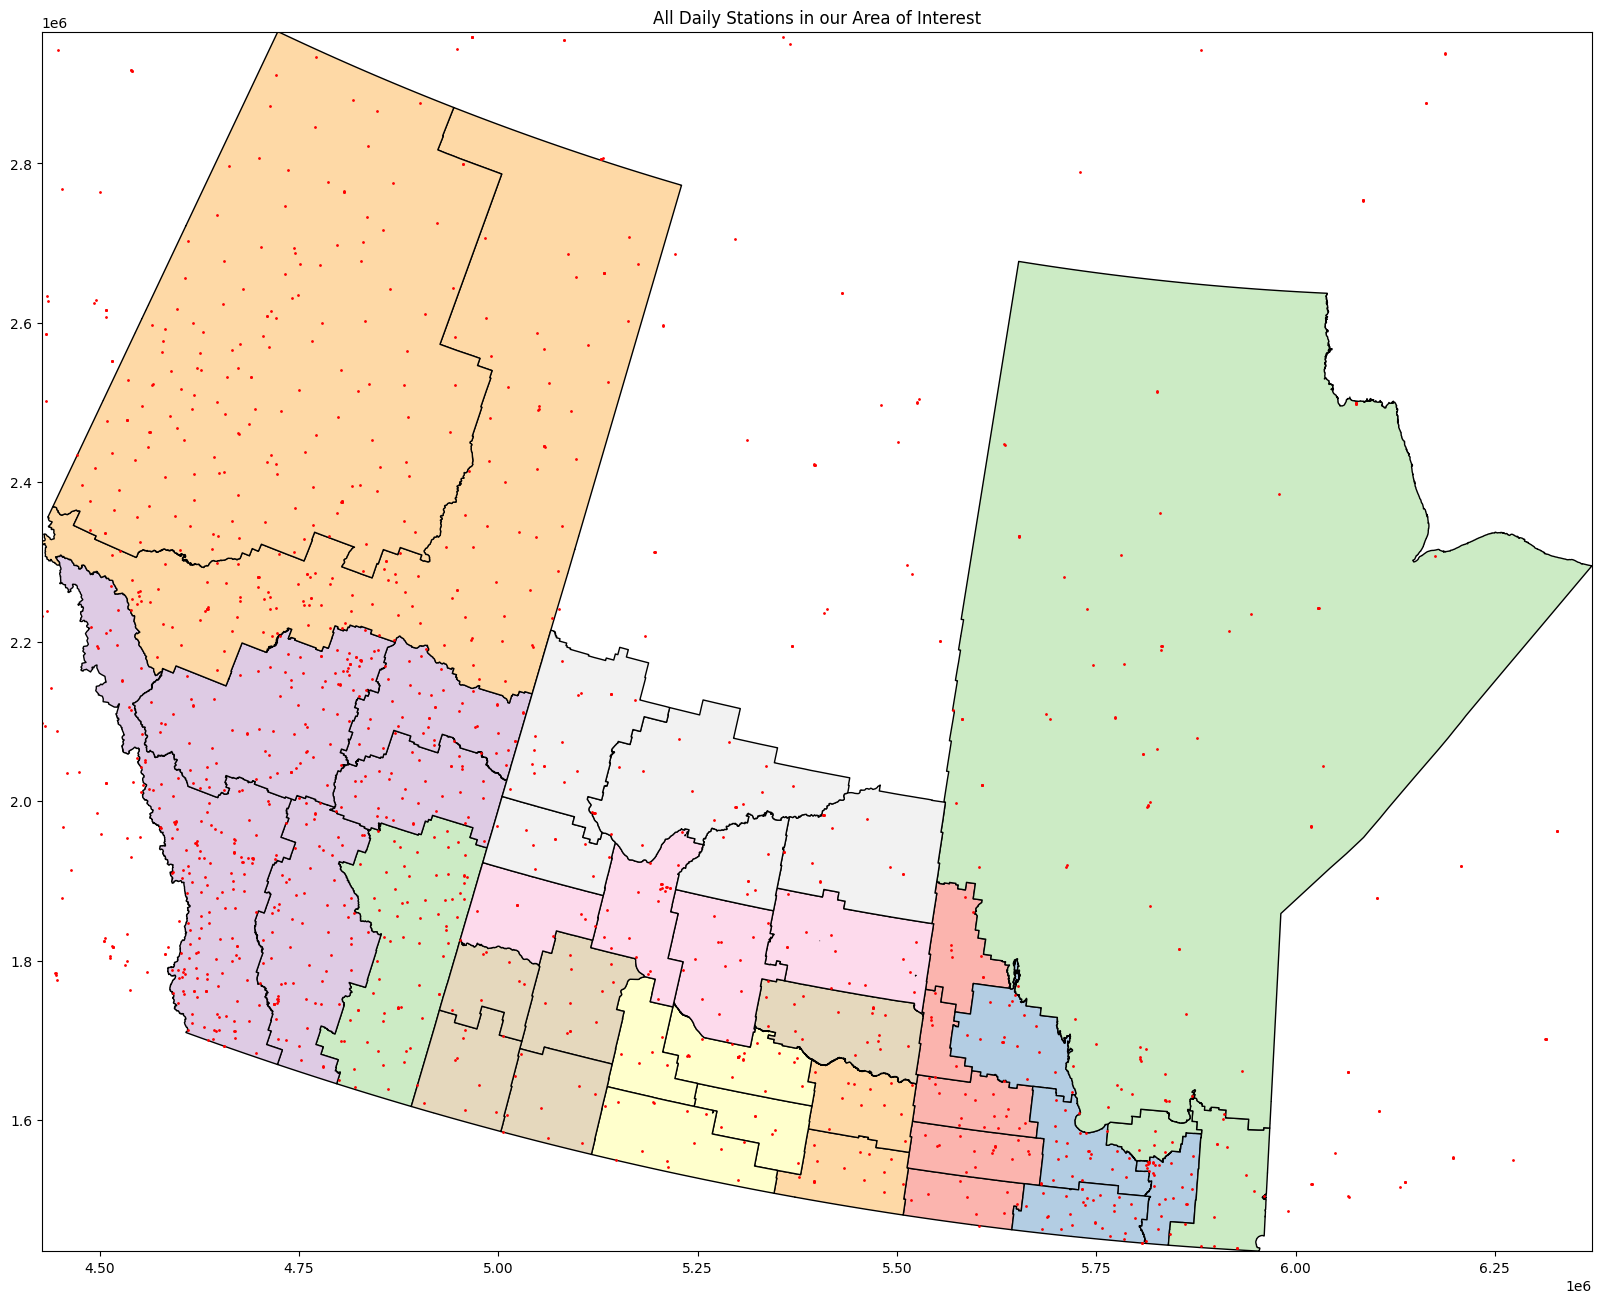

In [15]:
minx, miny, maxx, maxy = prunedRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("All Daily Stations in our Area of Interest")
prunedRegions.plot(ax=ax, cmap="Pastel1", edgecolor="black")
stationsDly.plot(ax=ax, color="red", markersize=1)

Purpose:  
Preprocessing before colors are associated with the agriculture regions

Pseudocode:  
- Define a list of colors to be used
- Assign the default color as grey (#808080)
- Assign the defaykt related districts group (0)
- [Cast CARuid into an integer](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html)

In [17]:
colors = [
    "#d3d3d3", # light grey
    "#556b2f", # dark green
    "#008080", # teal
    "#6495ed", # light blue
    "#00ff7f", # bright green
    "#db7093", # pink
    "#f0e68c", # yellow
    "#ffa07a", # salmon
    "#ee82ee", # violet
    "#1e90ff", # intense blue
    "#eee8aa", # pale
]

# create a new column to store a color for the region, default is gray
prunedRegions["color"] = "#808080" 

prunedRegions["CRnum"] = 0 # create a new column that groups related districts
prunedRegions["CARuid"] = prunedRegions["CARuid"].astype(int)

Purpose:  
Assigns each of the districts in Manitoba a district group and color

Pseudocode:  
- [Assign districts 4612, 4601, 4602, 4603, 4608 a CRnum of 3](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign districts 4604, 4605, 4606 a CRnum of 2](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign districts 4607, 4609, 4610, 4611 a CRnum of 1](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 3 to light grey](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 2 to dark green](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 1 to teal](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)

In [18]:
prunedRegions.loc[
    prunedRegions["CARuid"].isin([4612, 4601, 4602, 4603, 4608]), "CRnum"
] = 3

prunedRegions.loc[prunedRegions["CARuid"].isin([4604, 4605, 4606]), "CRnum"] = 2
prunedRegions.loc[prunedRegions["CARuid"].isin([4607, 4609, 4610, 4611]), "CRnum"] = 1

prunedRegions.loc[prunedRegions["CRnum"] == 3, "color"] = colors[0]
prunedRegions.loc[prunedRegions["CRnum"] == 2, "color"] = colors[1]
prunedRegions.loc[prunedRegions["CRnum"] == 1, "color"] = colors[2]

Purpose:  
Assigns each of the districts in Alberta a district group and color

Pseudocode:  
- [Assign districts 4810, 4820, 4830 a CRnum of 8](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign districts 4840, 4841, 4850 a CRnum of 9](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign districts 4860, 4870 a CRnum of 10](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 8 to light blue](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 9 to bright green](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 10 to intense blue](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)

In [19]:
prunedRegions.loc[prunedRegions["CARuid"].isin([4810, 4820, 4830]), "CRnum"] = 8
prunedRegions.loc[prunedRegions["CARuid"].isin([4840, 4841, 4850]), "CRnum"] = 9
prunedRegions.loc[prunedRegions["CARuid"].isin([4860, 4870]), "CRnum"] = 10

prunedRegions.loc[prunedRegions["CRnum"] == 8, "color"] = colors[3]
prunedRegions.loc[prunedRegions["CRnum"] == 9, "color"] = colors[4]
prunedRegions.loc[prunedRegions["CRnum"] == 10, "color"] = colors[10]

Purpose:  
Assigns each of the districts in Saskatchewan a district group and color

Pseudocode:  
- [Assign districts 4710, 4711, 4720, 4721, 4731 a CRnum of 4](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign districts 4730, 4732, 4733, 4740, 4741 a CRnum of 5](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign districts 4750, 4751, 4760, 4780, 4781 a CRnum of 6](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign districts 4761, 4770, 4771, 4790, 4791 a CRnum of 7](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 4 to pink](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 5 to salmon](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 6 to yellow](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Assign CRnum 7 to violet](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)

In [20]:
prunedRegions.loc[
    prunedRegions["CARuid"].isin([4710, 4711, 4720, 4721, 4731]), "CRnum"
] = 4
prunedRegions.loc[
    prunedRegions["CARuid"].isin([4730, 4732, 4733, 4740, 4741]), "CRnum"
] = 5
prunedRegions.loc[
    prunedRegions["CARuid"].isin([4750, 4751, 4760, 4780, 4781]), "CRnum"
] = 6
prunedRegions.loc[
    prunedRegions["CARuid"].isin([4761, 4770, 4771, 4790, 4791]), "CRnum"
] = 7

prunedRegions.loc[prunedRegions["CRnum"] == 4, "color"] = colors[5]
prunedRegions.loc[prunedRegions["CRnum"] == 5, "color"] = colors[7]
prunedRegions.loc[prunedRegions["CRnum"] == 6, "color"] = colors[6]
prunedRegions.loc[prunedRegions["CRnum"] == 7, "color"] = colors[8]

Purpose:  
Creates a region plot for the pruned agriculture regions (only shows Alberta, Manitoba and Saskatchewan) colored by their groupings

Psuedocode:  
- [Generate the minimum and maximum bounds of the geography](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html)
- [Create a subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)
- [Assign the vertical view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylim.html)
- [Assign the hoirzontal view limit](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html)
- [Assign a title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)
- [Plot the geometry/districts](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

<Axes: title={'center': 'The Area of Interest colored by their groupings'}>

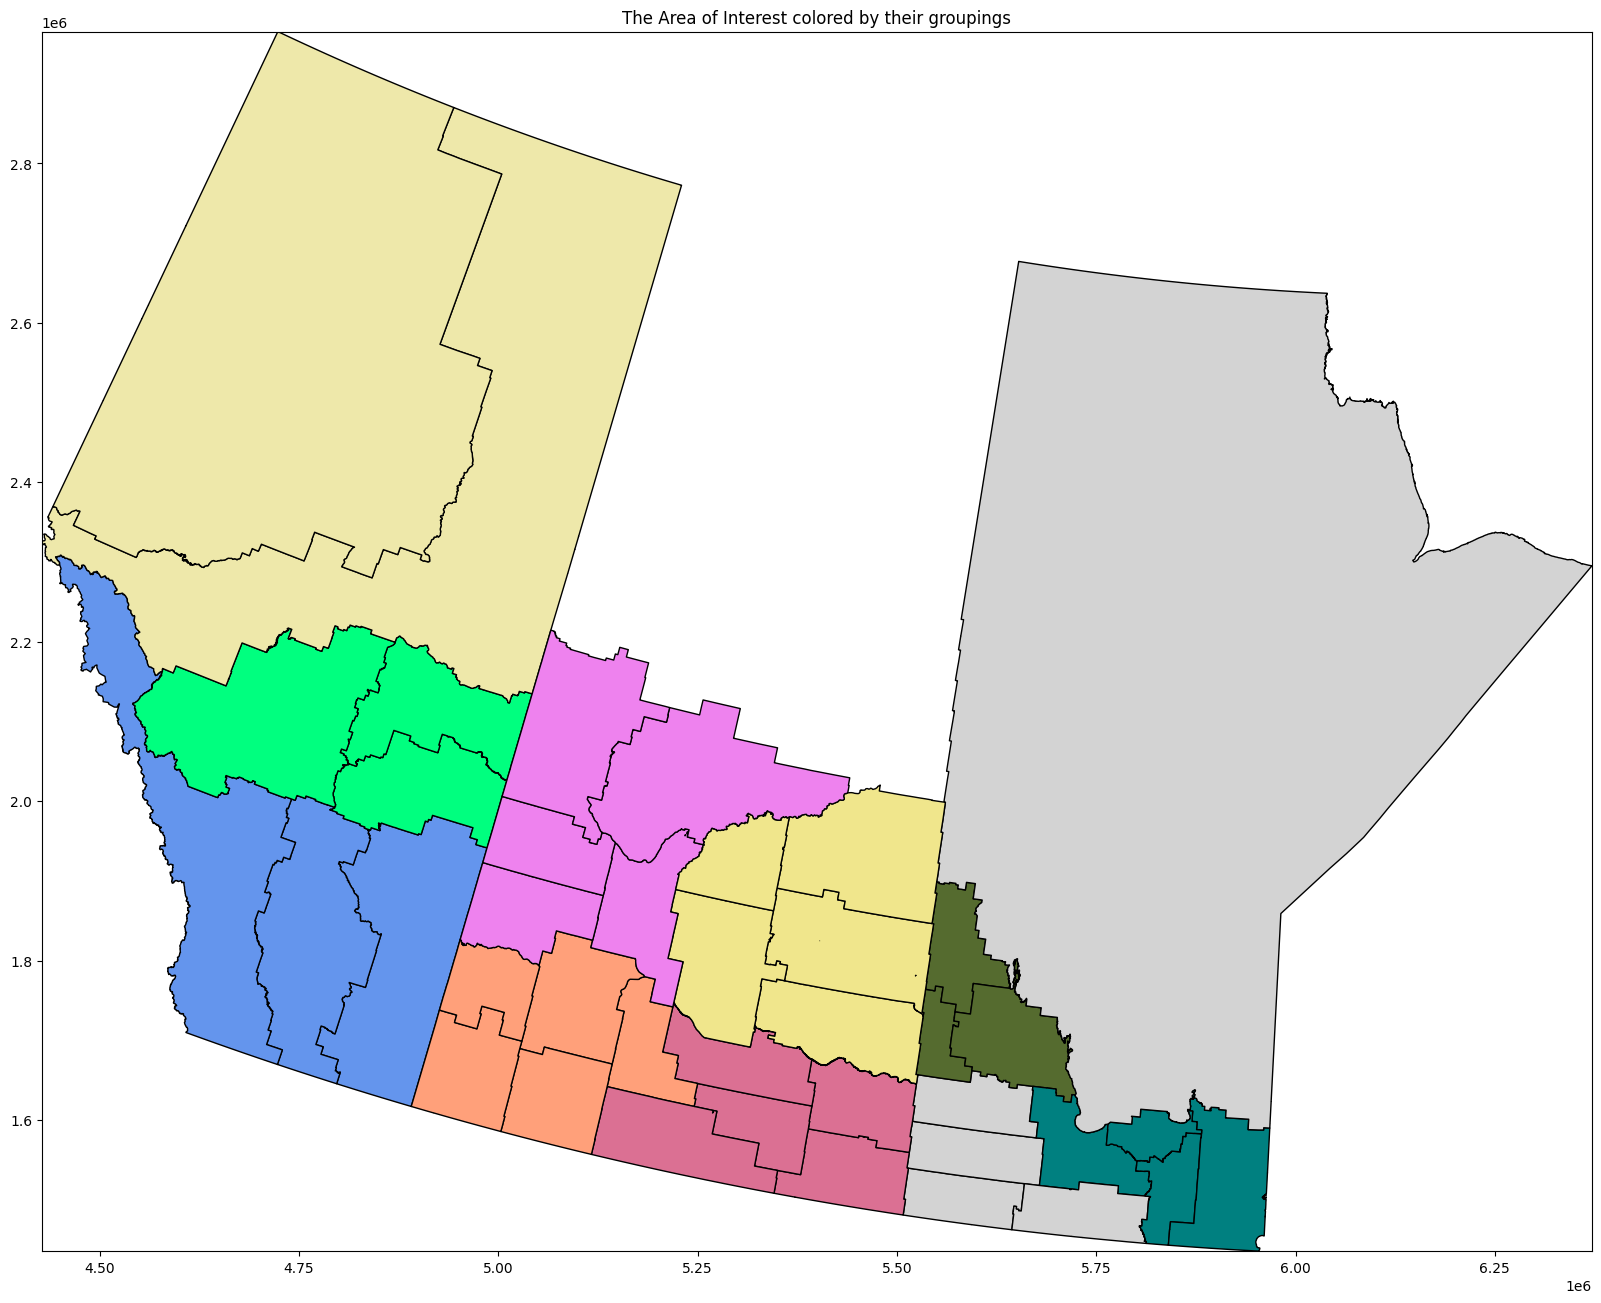

In [22]:
minx, miny, maxx, maxy = prunedRegions.total_bounds
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy)
ax.set_xlim(minx, maxx)
ax.set_title("The Area of Interest colored by their groupings")
prunedRegions.plot(ax=ax, color=prunedRegions["color"], edgecolor="black")

Purpose:  
Joins the station and region data together (stations that fall outside the area of interest are removed)

Psuedocode:  
- [Join](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html) the stations and the prunedRegions together
    - how=inner specifies that all stations that do not fall within one of the pruned regions are removed
    - predicate=within specifies that all stations should fall within a pruned region
- [Drop irrelevant columns](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)

In [23]:
prunedStationsDly = stationsDly.sjoin(prunedRegions, how="inner", predicate="within")
prunedStationsHly = stationsHly.sjoin(prunedRegions, how="inner", predicate="within")

prunedStationsHly.drop(
    columns=["index_right", "CARname", "PRuid", "AGuid", "color"], inplace=True
)

prunedStationsDly.drop(
    columns=["index_right", "CARname", "PRuid", "AGuid", "color"], inplace=True
)

Purpose:  
Add a scraped attribute to the stations

Remark: This attribute was never used

In [ ]:
prunedStationsDly["scraped"] = False
prunedStationsHly["scraped"] = False

Purpose:  
For each station, assign the provinces abbreviation rather then the full name

Pseudocode:  
- [Assign province](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) for stations within Alberta as AB
- [Assign province](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) for stations within Manitoba as MB
- [Assign province](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) for stations within Saskatchewan as SK

In [ ]:
prunedStationsDly.loc[prunedStationsDly["Province"] == "ALBERTA", "province"] = "AB"
prunedStationsHly.loc[prunedStationsHly["Province"] == "ALBERTA", "province"] = "AB"

prunedStationsDly.loc[prunedStationsDly["Province"] == "MANITOBA", "province"] = "MB"
prunedStationsHly.loc[prunedStationsHly["Province"] == "MANITOBA", "province"] = "MB"

prunedStationsDly.loc[prunedStationsDly["Province"] == "SASKATCHEWAN", "province"] = "SK"
prunedStationsHly.loc[prunedStationsHly["Province"] == "SASKATCHEWAN", "province"] = "SK"

Purpose:  
[Renames the columns](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html) for prunedRegions, prunedStationsDly and prunedStationsHly

In [ ]:
prunedRegions.rename(columns={"CARuid": "district"}, inplace=True)
prunedRegions.rename(columns={"CARname": "car_name"}, inplace=True)
prunedRegions.rename(columns={"PRuid": "pr_uid"}, inplace=True)
prunedRegions.rename(columns={"AGuid": "ag_uid"}, inplace=True)
prunedRegions.rename(columns={"CRnum": "cr_num"}, inplace=True)

# daily stations
prunedStationsDly.rename(columns={"Station Name": "station_name"}, inplace=True)
prunedStationsDly.rename(columns={"CARuid": "district"}, inplace=True)
prunedStationsDly.rename(columns={"Province": "province"}, inplace=True)
prunedStationsDly.rename(columns={"Latitude": "latitude"}, inplace=True)
prunedStationsDly.rename(columns={"Longitude": "longitude"}, inplace=True)
prunedStationsDly.rename(columns={"Elevation": "elevation"}, inplace=True)
prunedStationsDly.rename(columns={"Climate ID": "station_id"}, inplace=True)
prunedStationsDly.rename(columns={"WMO Identifier": "wmo_identifier"}, inplace=True)
prunedStationsDly.rename(columns={"TC Identifier": "tc_identifier"}, inplace=True)
prunedStationsDly.rename(columns={"First Year": "first_year"}, inplace=True)
prunedStationsDly.rename(columns={"Last Year": "last_year"}, inplace=True)
prunedStationsDly.rename(columns={"HLY First Year": "hly_first_year"}, inplace=True)
prunedStationsDly.rename(columns={"HLY Last Year": "hly_last_year"}, inplace=True)
prunedStationsDly.rename(columns={"DLY First Year": "dly_first_year"}, inplace=True)
prunedStationsDly.rename(columns={"DLY Last Year": "dly_last_year"}, inplace=True)
prunedStationsDly.rename(columns={"MLY First Year": "mly_first_year"}, inplace=True)
prunedStationsDly.rename(columns={"MLY Last Year": "mly_last_year"}, inplace=True)
prunedStationsDly.rename(columns={"CRnum": "cr_num"}, inplace=True)

# hourly stations
prunedStationsHly.rename(columns={"Station Name": "station_name"}, inplace=True)
prunedStationsHly.rename(columns={"CARuid": "district"}, inplace=True)
prunedStationsHly.rename(columns={"Province": "province"}, inplace=True)
prunedStationsHly.rename(columns={"Latitude": "latitude"}, inplace=True)
prunedStationsHly.rename(columns={"Longitude": "longitude"}, inplace=True)
prunedStationsHly.rename(columns={"Elevation": "elevation"}, inplace=True)
prunedStationsHly.rename(columns={"Climate ID": "station_id"}, inplace=True)
prunedStationsHly.rename(columns={"WMO Identifier": "wmo_identifier"}, inplace=True)
prunedStationsHly.rename(columns={"TC Identifier": "tc_identifier"}, inplace=True)
prunedStationsHly.rename(columns={"First Year": "first_year"}, inplace=True)
prunedStationsHly.rename(columns={"Last Year": "last_year"}, inplace=True)
prunedStationsHly.rename(columns={"HLY First Year": "hly_first_year"}, inplace=True)
prunedStationsHly.rename(columns={"HLY Last Year": "hly_last_year"}, inplace=True)
prunedStationsHly.rename(columns={"DLY First Year": "dly_first_year"}, inplace=True)
prunedStationsHly.rename(columns={"DLY Last Year": "dly_last_year"}, inplace=True)
prunedStationsHly.rename(columns={"MLY First Year": "mly_first_year"}, inplace=True)
prunedStationsHly.rename(columns={"MLY Last Year": "mly_last_year"}, inplace=True)
prunedStationsHly.rename(columns={"CRnum": "cr_num"}, inplace=True)

Purpose:  
Combines districts 4840 and 4841 into a single district (4840)

Pseudocode:  
- [Fetch regions 4840 and 4841](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Merge their regions into a single geometry](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.unary_union.html)
- [Update the name of region 4840 to reflect the entirety of the district](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Update the stations with district number 4841](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)
- [Delete district 4841 from regions](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) (its been absorbed into 4840)

Remarks: if the data was loaded before this change was added, there is a script to easily modify the database found [here]()

In [ ]:
# get both rows corresponding to district 4840 and 4841 respectively
districts4841And4840 = prunedRegions.loc[
    (prunedRegions["district"] == 4840) | (prunedRegions["district"] == 4841)
]

# merge their geometries into the row with district 4840
prunedRegions.loc[
    prunedRegions["district"] == 4840, "geometry"
] = districts4841And4840.unary_union

# update the name to reflect the entirety of the district
prunedRegions.loc[
    prunedRegions["district"] == 4840, "car_name"
] = "Census Agricultural Region 4"

# updates the stations with district number 4841
prunedStationsDly.loc[prunedStationsDly["district"] == 4841, "district"] = 4840
prunedStationsHly.loc[prunedStationsDly["district"] == 4841, "district"] = 4840

# delete district 4841 which is now apart of 4840
prunedRegions.drop(prunedRegions.loc[prunedRegions["district"] == 4841].index, inplace=True)

Purpose:  
Loads the regions and stations into the database

Tables:  
- [census_ag_regions](https://github.com/ChromaticPanic/CGC_Grain_Outcome_Predictions#census_ag_regions)
- [stations_dly](https://github.com/ChromaticPanic/CGC_Grain_Outcome_Predictions#stations_dly)
- [stations_hly](https://github.com/ChromaticPanic/CGC_Grain_Outcome_Predictions#stations_hly)

Pseudocode:  
- Connect to the database
- [Load the regions into the database](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_postgis.html)
- [Load the daily stations into the database](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_postgis.html)
- [Load the hourly stations into the database](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_postgis.html)
- Disconnect from the database

In [ ]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    raise ValueError("Environment variables not set")

db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
conn = db.connect()

prunedRegions.to_postgis(REGIONS_TABLE, conn, index=False, if_exists="replace")
prunedStationsDly.to_postgis(DLY_STATIONS_TABLE, conn, index=False, if_exists="replace")
prunedStationsHly.to_postgis(HLY_STATIONS_TABLE, conn, index=False, if_exists="replace")

db.cleanup()